In [1]:
import os
import glob
import random
import copy
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from MEDLA import *

In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(0)

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

encoder_channel = [8, 16, 32] # Channels of encoder1, encoder2 are the same
encoder_channel2 = [8, 16, 32]
encoder1_kernel = [16, 8, 4]
encoder2_kernel = [16, 8, 4]
encoder1_pool = [4, 4, 4]
encoder2_pool = [4, 4, 4]

MEDLA_model = MEDLA(en1_chan_list = encoder_channel, en2_chan_list = encoder_channel2, en1_pool_list = encoder1_pool,
                en1_ker_list = encoder1_kernel, en2_pool_list = encoder2_pool, en2_ker_list = encoder2_kernel)
MEDLA_model = MEDLA_model.to(device)

MEDLA_model.load_state_dict(torch.load('MEDLA_BCE_ft.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [4]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

class DropsLSTM(nn.Module):
    def __init__(self, hidden_layers=100, n_layer=2):
        super(DropsLSTM, self).__init__()
        self.hidden_layers = hidden_layers
        self.n_layer = n_layer
        # lstm1, lstm2, linear are all layers in the network
        self.lstm = torch.nn.LSTM(input_size = 16, hidden_size = self.hidden_layers,
                                  num_layers = self.n_layer, batch_first=True)
        self.linear = nn.Sequential(
                                    nn.Linear(self.hidden_layers, self.hidden_layers),
                                    nn.LeakyReLU(),
                                    #nn.Dropout(p=0.1),
                                    nn.Linear(self.hidden_layers, self.hidden_layers),
                                    nn.LeakyReLU(),
                                    nn.Dropout(p=0.1),
                                    nn.Linear(self.hidden_layers, 16),
                                    #nn.LeakyReLU(negative_slope=0.3)
                                    )
        
    def forward(self, x):
        out,_ = self.lstm(x)
        out = self.linear(out)
        return out
    
    def init_hidden(self, batch_size):
        hidden_state = torch.randn(self.n_layer,batch_size,self.hidden_layers)
        cell_state = torch.randn(self.n_layer,batch_size,self.hidden_layers)
        self.hidden = (hidden_state, cell_state)

class LSTM_Trainer:
    def __init__(self, *, dataloader_dict: dict, model, lr: float, num_epoch: int):
        self.dataloader_dict = dataloader_dict
        self.model = model
        self.lr = lr
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, mode="min", patience=50, verbose=True)
        self.best_wts = copy.deepcopy(self.model.state_dict())
        self.best_loss = np.inf
        self.criterion = nn.MSELoss()
        self.num_epoch = num_epoch
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        #self.device = torch.device("cpu")
        print(f"Using {self.device} device")
        print("PyTorch Version: ",torch.__version__)
        
        self.model.to(self.device)

    def _do_epoch(self, epoch: int, phase: str):
        running_loss = 0.
        sample_num = len(self.dataloader_dict[phase].sampler)
        if phase == 'train':
            self.model.train()
        else:
            self.model.eval()
        for inputs, labels in self.dataloader_dict[phase]:
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)
            # forward
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            if phase == "train":
                # backward
                loss.backward()
                self.optimizer.step()
            running_loss += loss.item()*inputs.size(0)
        return running_loss/sample_num
    
    def run(self):
        for epoch in range(self.num_epoch):
            train_loss = self._do_epoch(epoch, "train")
            with torch.no_grad():
                val_loss = self._do_epoch(epoch, "val")
                self.scheduler.step(val_loss)
            if val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_wts = copy.deepcopy(self.model.state_dict())  
                torch.save(self.model.state_dict(), "best_lstm.pth")
            if epoch % 10 == 0:
                print(f"Epoch {epoch+1}/{self.num_epoch}, train_loss: {train_loss:>7f}, val_loss: {val_loss:>7f}")
        print('LSTM training end\n')

In [5]:
seq_length=5
def getTrain(seq_length:int):
    encoded_dir_list = glob.glob('encoded_traj_BCE/exp/*_03_*.npy')
    sample_arr = np.zeros((0,seq_length,16))
    label_arr = np.zeros((0,seq_length,16))
    for dir in encoded_dir_list:
        encoded = np.load(dir)
        num_seq = encoded.shape[0]-2*seq_length+1
        for i in range(num_seq):
            sample_arr = np.concatenate((sample_arr, encoded[i:i+seq_length].reshape(1,seq_length,16)), axis=0)
            label_arr = np.concatenate((label_arr, encoded[i+seq_length:i+2*seq_length].reshape(1,seq_length,16)), axis=0)
    return sample_arr, label_arr

def getFullTrain(seq_length:int):
    encoded_dir_list = glob.glob('encoded_traj_BCE/0306/*.npy')
    sample_arr = np.zeros((0,seq_length,16))
    label_arr = np.zeros((0,seq_length,16))
    for dir in encoded_dir_list:
        encoded = np.load(dir)
        num_seq = encoded.shape[0]-2*seq_length+1
        for i in range(num_seq):
            sample_arr = np.concatenate((sample_arr, encoded[i:i+seq_length].reshape(1,seq_length,16)), axis=0)
            label_arr = np.concatenate((label_arr, encoded[i+seq_length:i+2*seq_length].reshape(1,seq_length,16)), axis=0)
    return sample_arr, label_arr


x_train, y_train = getFullTrain(seq_length)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0, shuffle=True)

train_dataset_lstm = timeseries(x_train,y_train)
val_dataset_lstm = timeseries(x_val, y_val)
train_dataloader_lstm = DataLoader(train_dataset_lstm, batch_size=32)
val_dataloader_lstm = DataLoader(val_dataset_lstm, batch_size=32)

dataloader_dict_lstm ={'train' : train_dataloader_lstm, 'val' : val_dataloader_lstm}

In [6]:
LSTM_model = DropsLSTM(128, 3)

In [7]:
lstm_trainer = LSTM_Trainer(dataloader_dict=dataloader_dict_lstm, model=LSTM_model, lr= 0.01, num_epoch=1000)

Using cuda:0 device
PyTorch Version:  2.0.1


In [8]:
lstm_trainer.run()

Epoch 1/1000, train_loss: 3.757619, val_loss: 2.036013
Epoch 11/1000, train_loss: 0.187566, val_loss: 0.124734
Epoch 21/1000, train_loss: 0.147523, val_loss: 0.089333
Epoch 31/1000, train_loss: 0.125313, val_loss: 0.056561
Epoch 41/1000, train_loss: 0.189053, val_loss: 0.171985
Epoch 51/1000, train_loss: 0.120140, val_loss: 0.057972
Epoch 61/1000, train_loss: 0.117134, val_loss: 0.042588
Epoch 71/1000, train_loss: 0.123993, val_loss: 0.048075
Epoch 81/1000, train_loss: 0.113963, val_loss: 0.044925
Epoch 91/1000, train_loss: 0.107395, val_loss: 0.034152
Epoch 101/1000, train_loss: 0.106999, val_loss: 0.061862
Epoch 111/1000, train_loss: 0.098600, val_loss: 0.033816
Epoch 121/1000, train_loss: 0.107440, val_loss: 0.056165
Epoch 00128: reducing learning rate of group 0 to 1.0000e-03.
Epoch 131/1000, train_loss: 0.077918, val_loss: 0.011983
Epoch 141/1000, train_loss: 0.074778, val_loss: 0.009538
Epoch 151/1000, train_loss: 0.073043, val_loss: 0.010073
Epoch 161/1000, train_loss: 0.073542,

In [9]:
def getTest(seq_length:int):
    encoded_dir_list = np.sort(glob.glob('encoded_traj_BCE/exp/*1_06_*.npy'))
    encoded_cfd_dir_list = np.sort(glob.glob('encoded_traj_BCE/cfd/*1_06_*.npy'))
    print(encoded_dir_list)
    print(encoded_cfd_dir_list)
    sample_arr = np.zeros((0,seq_length,16))
    label_arr = np.zeros((0,seq_length,16))
    cfd_arr = np.zeros((0,seq_length,16))
    num_set = encoded_dir_list.shape[0]
    for (dir, cfd_dir) in zip(encoded_dir_list, encoded_cfd_dir_list):
        encoded = np.load(dir)
        cfd_encoded = np.load(cfd_dir)
        num_seq = int(encoded.shape[0]/seq_length)-1
        for i in range(num_seq):
            sample_arr = np.concatenate((sample_arr, encoded[i*seq_length:(i+1)*seq_length].reshape(1,seq_length,16)), axis=0)
            label_arr = np.concatenate((label_arr, encoded[(i+1)*seq_length:(i+2)*seq_length].reshape(1,seq_length,16)), axis=0)
            cfd_arr = np.concatenate((cfd_arr, cfd_encoded[(i+1)*seq_length:(i+2)*seq_length].reshape(1,seq_length,16)), axis=0)
    return sample_arr, label_arr, cfd_arr, num_set

In [10]:
x_test, y_test, cfd_test, num_set = getTest(seq_length) #304 datasets

['encoded_traj_BCE/exp/exp_01_06_C13_encoded.npy'
 'encoded_traj_BCE/exp/exp_01_06_C1_encoded.npy'
 'encoded_traj_BCE/exp/exp_1_06_part2_NC14_encoded.npy']
['encoded_traj_BCE/cfd/cfd_01_06_C13_encoded.npy'
 'encoded_traj_BCE/cfd/cfd_01_06_C1_encoded.npy'
 'encoded_traj_BCE/cfd/cfd_1_06_part2_NC14_encoded.npy']


In [11]:
LSTM_model.load_state_dict(torch.load('best_lstm.pth'))
LSTM_model.to(device)

DropsLSTM(
  (lstm): LSTM(16, 128, num_layers=3, batch_first=True)
  (linear): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Dropout(p=0.1, inplace=False)
    (5): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [12]:
B_coeff = 0.2
def VAR_3D(xb,Y,H,B,R): #booleen=0 garde la trace
    # xb: priori, Y: observation, H: obs. matrix, B: priori estimate uncertainty
    # R: Measurement uncertainty
    dim_x = xb.size
    #dim_y = Y.size
    Y.shape = (Y.size,1)
    xb1=np.copy(xb)
    xb1.shape=(xb1.size,1)
    K=np.dot(B,np.dot(np.transpose(H),np.linalg.pinv(np.dot(H,np.dot(B,np.transpose(H)))+R))) #matrice de gain
    
    A=np.dot(np.dot((np.eye(dim_x)-np.dot(K,H)),B),np.transpose((np.eye(dim_x)-np.dot(K,H))))+np.dot(np.dot(K,R),np.transpose(K))
    vect=np.dot(H,xb1)
    xa=np.copy(xb1+np.dot(K,(Y-vect)))
    return xa.ravel(),A

def getPred(inputs):
    inputs = inputs.reshape(num_set,-1,seq_length,16)
    #labels = labels.reshape(8,38,5,16)
    starts = inputs[:,0,:,:]
    preds = torch.zeros_like(inputs)
    for i in range(inputs.shape[0]):
        for j in range(inputs.shape[1]):
            if j == 0:
                current_state = starts[i]
            current_state = LSTM_model(current_state)
            preds[i][j] = current_state.reshape(seq_length,16)
    return preds

def getDAPred(inputs,labels,cfd):
    inputs = inputs.reshape(num_set,-1,seq_length,16)
    labels = labels.reshape(num_set,-1,seq_length,16)
    cfd = cfd.reshape(num_set,-1,seq_length,16)
    starts = inputs[:,0,:,:]
    preds = torch.zeros_like(inputs)
    latent_size = int(seq_length*16)
    for i in range(inputs.shape[0]):
        for j in range(inputs.shape[1]):
            if j == 0:
                current_state = starts[i]
            current_state = LSTM_model(current_state)
            if j != 0:
                xa_seq,_ = VAR_3D(current_state.cpu().detach().numpy().ravel(),cfd[i][j].ravel(),np.eye(latent_size),B_coeff*np.eye(latent_size),np.eye(latent_size))
                current_state = torch.tensor(xa_seq.reshape(seq_length,16), dtype=torch.float32, device=device)
            preds[i][j] = current_state.reshape(seq_length,16)
    return preds

In [13]:
preds = getPred(torch.tensor(x_test, dtype=torch.float32, device=device))
preds.shape

torch.Size([3, 38, 5, 16])

In [14]:
DA_preds = getDAPred(torch.tensor(x_test, dtype=torch.float32, device=device),
                     torch.tensor(y_test, dtype=torch.float32, device=device),
                     cfd_test)
DA_preds.shape

torch.Size([3, 38, 5, 16])

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


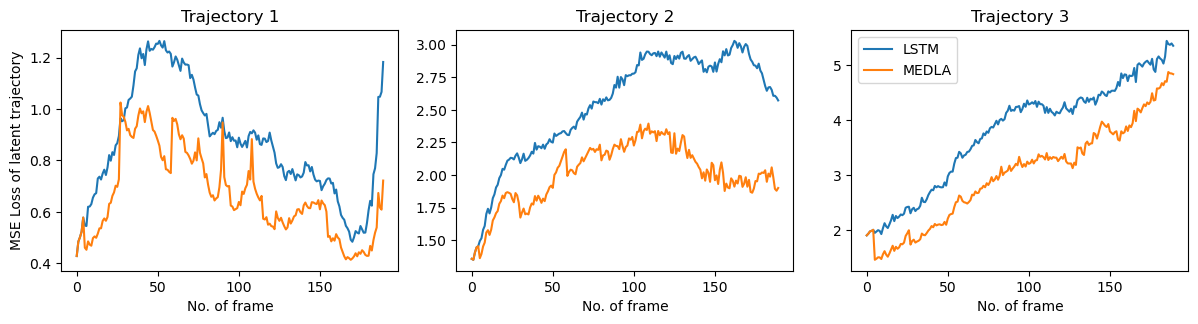

In [15]:
labels = torch.tensor(y_test.reshape(num_set,-1,5,16), dtype=torch.float32, device=device)
flat_preds = preds.reshape(labels.shape[0], -1, 16)
flat_DA_preds = DA_preds.reshape(labels.shape[0],-1,16)
flat_label = labels.reshape(labels.shape[0], -1, 16)
fig, axs = plt.subplots(1,3, figsize=(12,3), sharex=True)
fig.tight_layout()
axs =axs.flatten()
lstm_err = np.array(())
DA_err = np.array(())
DAMod_err = np.array(())
for i in range(labels.shape[0]):
    tmp_err = torch.zeros(flat_label.shape[1])
    tmp_DA_err = torch.zeros(flat_label.shape[1])
    tmp_cfd_err = torch.zeros(flat_label.shape[1])
    for j in range(flat_label.shape[1]):
        tmp_err[j] = torch.nn.functional.mse_loss(flat_preds[i][j], flat_label[i][j], reduction='sum')/torch.norm(flat_label[i][j], p=1)
        tmp_DA_err[j] = torch.nn.functional.mse_loss(flat_DA_preds[i][j], flat_label[i][j], reduction='sum')/torch.norm(flat_label[i][j], p=1)
    axs[i].plot(tmp_err.detach().numpy(), label = 'LSTM')
    axs[i].plot(tmp_DA_err.detach().numpy(), label = 'MEDLA')
    lstm_err = np.concatenate((lstm_err, tmp_err.detach().numpy()))
    DA_err = np.concatenate((DA_err, tmp_DA_err.detach().numpy()))
axs[2].legend()
axs[0].set_ylabel('MSE Loss of latent trajectory')
axs[0].set_xlabel('No. of frame')
axs[1].set_xlabel('No. of frame')
axs[2].set_xlabel('No. of frame')
axs[0].set_title('Trajectory 1')
axs[1].set_title('Trajectory 2')
axs[2].set_title('Trajectory 3')
plt.savefig('Drop_3_traj.eps')

In [16]:
tmp_err = lstm_err
print('LSTM MSE:')
print(tmp_err[:190].shape,np.mean(tmp_err[:190]))
print(tmp_err[190:380].shape,np.mean(tmp_err[190:380]))
print(tmp_err[380:570].shape,np.mean(tmp_err[380:570]))
print('LSTM RMSE:')
print(tmp_err[:190].shape,np.sqrt(np.mean(tmp_err[:190])))
print(tmp_err[190:380].shape,np.sqrt(np.mean(tmp_err[190:380])))
print(tmp_err[380:570].shape,np.sqrt(np.mean(tmp_err[380:570])))

LSTM MSE:
(190,) 0.8666607199530852
(190,) 2.5395591553888823
(190,) 3.7808181254487288
LSTM RMSE:
(190,) 0.9309461423482485
(190,) 1.593599433794102
(190,) 1.9444325973015184


In [17]:
tmp_err = DA_err
print('LSTM MSE:')
print(tmp_err[:190].shape,np.mean(tmp_err[:190]))
print(tmp_err[190:380].shape,np.mean(tmp_err[190:380]))
print(tmp_err[380:570].shape,np.mean(tmp_err[380:570]))
print('LSTM RMSE:')
print(tmp_err[:190].shape,np.sqrt(np.mean(tmp_err[:190])))
print(tmp_err[190:380].shape,np.sqrt(np.mean(tmp_err[190:380])))
print(tmp_err[380:570].shape,np.sqrt(np.mean(tmp_err[380:570])))

LSTM MSE:
(190,) 0.6656601973270115
(190,) 2.0087871959334924
(190,) 3.0190766466291326
LSTM RMSE:
(190,) 0.81588001405048
(190,) 1.4173169003202821
(190,) 1.737549034309286
